In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.multioutput import MultiOutputClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

from gensim.models import Word2Vec

In [21]:
df = pd.read_csv('data/train.csv/train.csv')
total = df.shape[0]
print('rows:', df.shape[0])
# toxic,severe_toxic,obscene,threat,insult,identity_hate
print('# toxic:', df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)].shape[0])

print('# toxic:', 1-df[(df['toxic'] == 1)].shape[0]/total)
print('# severe_toxic:', 1-df[(df['severe_toxic'] == 1)].shape[0]/total)
print('# obscene:', 1-df[(df['obscene'] == 1)].shape[0]/total)
print('# threat:', 1-df[(df['threat'] == 1)].shape[0]/total)
print('# insult:', 1-df[(df['insult'] == 1)].shape[0]/total)
print('# identity_hate:', 1-df[(df['identity_hate'] == 1)].shape[0]/total)

rows: 159571
# toxic: 16225
# toxic: 0.9041555169799024
# severe_toxic: 0.9900044494300343
# obscene: 0.947051782592075
# threat: 0.9970044682304429
# insult: 0.9506363938309592
# identity_hate: 0.9911951419744189


### Preprocessing

In [22]:
''' 
resampling - undersampling
'''

# Count the number of labels per row (you might already have this)
df['label_count'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
print(df['label_count'].sum())
print(df.shape[0]*6)
print(df['label_count'].sum()/(df.shape[0]*6))
# Separate the minority and majority instances
minority_df = df[df['label_count'] > 0]     # s = 16k
majority_df = df[df['label_count'] == 0]

# Under-sample the majority dataframe
sampled_majority_df = majority_df.sample(n=len(minority_df))

# Combine back the minority and downsampled majority instances
balanced_df = pd.concat([minority_df, sampled_majority_df])

# Now balanced_df is the under-sampled DataFrame
df = balanced_df
print(df.shape[0])

35098
957426
0.03665870782702788
32450


In [4]:
''' 
Additional Functions
'''
def document_vector(word2vec_model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word2vec_model.wv[doc], axis=0)

In [5]:
'''
Basic Data Cleaning and Preprocessing
NOTE:
run time: 30 to 40 sec
Tokenization: turn text into tokens
Lemmatization: extracting a word's base form (ex: running -> run)
'''


# remove line breaks and special characters
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'\n', ' ', x))
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
print(df['comment_text'][6])

vectorizers = []
word2vec_model = Word2Vec(df['comment_text'], vector_size=300, window=5, min_count=1, workers=4)
vectorizers.append(word2vec_model)

# Convert to lowercase
df['comment_text'] = df['comment_text'].apply(lambda x: x.lower())
print(df['comment_text'][6])

# Tokenization
df['comment_text'] = df['comment_text'].apply(lambda x: nltk.word_tokenize(x))
print(df['comment_text'][6])


# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['comment_text'] = df['comment_text'].apply(lambda x: [word for word in x if word not in stop_words])
print(df['comment_text'][6])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['comment_text'] = df['comment_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(df['comment_text'][6])

vectorized_data = np.array([document_vector(word2vec_model, doc) for doc in df['comment_text']])

# Rejoin tokens into strings (for context for tfidf)
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join(x))
print(df['comment_text'][6])

# Example output
df['comment_text'].head()



COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
cocksucker before you piss around on my work
['cocksucker', 'before', 'you', 'piss', 'around', 'on', 'my', 'work']
['cocksucker', 'piss', 'around', 'work']
['cocksucker', 'piss', 'around', 'work']
cocksucker piss around work


6                           cocksucker piss around work
12    hey talk exclusive group wp talibanswho good d...
16         bye dont look come think comming back tosser
42    gay antisemmitian archangel white tiger meow g...
43                            fuck filthy mother as dry
Name: comment_text, dtype: object

In [6]:
''' 
Vectorization
'''

# Create Vectorizer and transform data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorized_data = tfidf_vectorizer.fit_transform(df['comment_text'])
print(tfidf_vectorized_data)



  (0, 71116)	0.3666274163479942
  (0, 8054)	0.4187207152669466
  (0, 49170)	0.5509478094281739
  (0, 15540)	0.6218631774551602
  (1, 69137)	0.13245244473758785
  (1, 45250)	0.21913091779295688
  (1, 35403)	0.11994111948360982
  (1, 10276)	0.15568290159206935
  (1, 15157)	0.1724009054958342
  (1, 58360)	0.26703751715092855
  (1, 8378)	0.1251194444547684
  (1, 45054)	0.2775609615174906
  (1, 19843)	0.22053417884727322
  (1, 7362)	0.2385241258158199
  (1, 4815)	0.2490475701823819
  (1, 51840)	0.11621512152934342
  (1, 8390)	0.2090668483792392
  (1, 46403)	0.08266361937502696
  (1, 27540)	0.1945425761466278
  (1, 51541)	0.25957101454894393
  (1, 56708)	0.22053417884727322
  (1, 19839)	0.20815608800948474
  (1, 28550)	0.10066779161511492
  (1, 62246)	0.2775609615174906
  (1, 71248)	0.31581778861623827
  :	:
  (32449, 6481)	0.08708166644558259
  (32449, 53823)	0.2124852894890848
  (32449, 39090)	0.21895052997496545
  (32449, 70894)	0.0699161323496786
  (32449, 39022)	0.13498293724520297
  (3

In [7]:
''' 
Train and Val split
'''

# Prepare the target variable
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df[label_columns]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectorized_data, y, test_size=0.2)

In [9]:
''' 
XGBoost grid search
'''

# Define XGBoost parameters grid
param_grid = {
    'max_depth': [64],
    'learning_rate': [0.001],
    'n_estimators': [500],
}

# Define fixed parameters
fixed_params = {
    'early_stopping_rounds': 10,
    'device': 'cuda'
}

# Scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average='weighted')  # Use 'weighted' for multi-class/multi-label
}

# Grid search for each label
for i in range(y_train.shape[1]):
    print('Start grid search for model', i)

    # Initialize XGBoost classifier with fixed parameters
    model = xgb.XGBClassifier(**fixed_params)

    # Set up the grid search with 3-fold cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='f1_score', cv=3, verbose=2)

    # Fit grid search
    grid_search.fit(X_train, y_train.iloc[:, i], eval_set=[(X_test, y_test.iloc[:, i])])

    # Best model, score, and parameters
    print(f"Best Model for label {i}: {grid_search.best_estimator_}")
    print(f"Best F1 Score for label {i}: {grid_search.best_score_}")
    print(f"Best Parameters for label {i}: {grid_search.best_params_}")

    # Display full results
    results = grid_search.cv_results_
    for mean_accuracy, mean_f1, params in zip(results['mean_test_accuracy'], results['mean_test_f1_score'], results['params']):
        print(f"Accuracy: {mean_accuracy}, F1 Score: {mean_f1}, Parameters: {params}")

Start grid search for model 0
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[0]	validation_0-logloss:1.00687
[1]	validation_0-logloss:0.68712
[2]	validation_0-logloss:1.04998
[3]	validation_0-logloss:0.73220
[4]	validation_0-logloss:1.28797
[5]	validation_0-logloss:0.98753
[6]	validation_0-logloss:1.64571
[7]	validation_0-logloss:1.27571
[8]	validation_0-logloss:0.89437
[9]	validation_0-logloss:1.56568
[10]	validation_0-logloss:1.20256
[CV] END learning_rate=0.001, max_depth=64, n_estimators=500; total time=  10.6s
[0]	validation_0-logloss:0.99828
[1]	validation_0-logloss:0.67947
[2]	validation_0-logloss:0.88615
[3]	validation_0-logloss:0.67628
[4]	validation_0-logloss:0.92977
[5]	validation_0-logloss:0.67729
[6]	validation_0-logloss:1.01959
[7]	validation_0-logloss:0.68971
[8]	validation_0-logloss:0.95061
[9]	validation_0-logloss:0.68452
[10]	validation_0-logloss:1.02463
[11]	validation_0-logloss:0.71294
[12]	validation_0-logloss:0.98148
[CV] END learning_rate=0.001, max_

KeyboardInterrupt: 

In [8]:
''' 
XGBoost
'''
# Define XGBoost parameters
params = {
    'max_depth': 16,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'early_stopping_rounds': 30,
    'min_child_weight': 0.1, 
    'device': 'cuda'
}

# List to store models for each label
models = []

# Fit a model for each label
for i in range(y_train.shape[1]):
    print('Start training of model', i)
    # Initialize the XGBoost classifier
    model = xgb.XGBClassifier(**params)
    
    # Fit with early stopping
    model.fit(X_train, y_train.iloc[:, i], eval_set=[(X_test, y_test.iloc[:, i])], verbose=False)
    
    # Store the fitted model
    models.append(model)

# Predictions
predictions = np.array([model.predict(X_test) for model in models]).T

# Evaluate the predictions
accuracy_scores = [accuracy_score(y_test.iloc[:, i], predictions[:, i]) for i in range(y_test.shape[1])]
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy (test): {:.2f}%".format(average_accuracy * 100))

predictions = np.array([model.predict(X_train) for model in models]).T
# Evaluate the predictions
accuracy_scores = [accuracy_score(y_train.iloc[:, i], predictions[:, i]) for i in range(y_train.shape[1])]
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy (train): {:.2f}%".format(average_accuracy * 100))

Start training of model 0
Start training of model 1
Start training of model 2
Start training of model 3
Start training of model 4
Start training of model 5
Average Accuracy (test): 84.05%
Average Accuracy (train): 84.05%


c:\Users\hrita\anaconda3\envs\dirac\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [9]:
''' 
Testing dataset (with preprocessing)
'''

# Load the test data
test_df = pd.read_csv('data/test.csv/test.csv')
test_labels_df = pd.read_csv('data/test_labels.csv/test_labels.csv')
# Find ids where any label is -1
ids_with_minus_one = test_labels_df[test_labels_df.eq(-1).any(axis=1)]['id']

# Filter out these ids from both dataframes
test_df_filtered = test_df[~test_df['id'].isin(ids_with_minus_one)]
test_labels_df_filtered = test_labels_df[~test_labels_df['id'].isin(ids_with_minus_one)]

# Now test_df_filtered and test_labels_df_filtered have rows with -1 labels removed
print(test_labels_df_filtered.shape[0])
test_df = test_df_filtered
test_labels_df = test_labels_df_filtered

#--------------------------------------------------------------------

# Merge the test data and labels on 'id'
test_merged_df = pd.merge(test_df, test_labels_df, on='id')
print(test_merged_df.head())

# Preprocess the text data (same as done with the training data)
# remove line breaks and special characters
test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: re.sub(r'\n', ' ', x))
test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
print(test_merged_df['comment_text'][0])

# # Convert to lowercase
# test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: x.lower())
# print(test_merged_df['comment_text'][0])

# Tokenization
test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: nltk.word_tokenize(x))
print(test_merged_df['comment_text'][0])

# Removing Stop Words
test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: [word for word in x if word not in stop_words])
print(test_merged_df['comment_text'][0])

# Lemmatization
test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(test_merged_df['comment_text'][0])

test_vectorized_data = np.array([document_vector(word2vec_model, doc) for doc in test_merged_df['comment_text']])

# Rejoin tokens into strings (for context for tfidf)
test_merged_df['comment_text'] = test_merged_df['comment_text'].apply(lambda x: ' '.join(x))
print(test_merged_df['comment_text'][0])

# Vectorize the text data using the same vectorizer as before
# IMPORTANT: Use transform() method, not fit_transform() as you don't want to refit it on test data
X_test = tfidf_vectorizer.transform(test_merged_df['comment_text'])
# X_test = test_vectorized_data

# Actual labels
y_test = test_merged_df.iloc[:, 2:]  # Assuming labels start from the 3rd column

# Predict using the trained models
predictions = np.array([model.predict(X_test) for model in models]).T

# Evaluate the predictions
accuracy_scores = [accuracy_score(y_test.iloc[:, i], predictions[:, i]) for i in range(y_test.shape[1])]
print(accuracy_scores)
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy: {:.2f}%".format(average_accuracy * 100))

print('True | pred')
for i in range(y_test.shape[0]):
    if (y_test.iloc[i, :] != predictions[i, :]).any():
        print(y_test.iloc[i, :].values, ' | ', predictions[i, :])

63978
                 id                                       comment_text  toxic  \
0  0001ea8717f6de06  Thank you for understanding. I think very high...      0   
1  000247e83dcc1211                   :Dear god this site is horrible.      0   
2  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...      0   
3  0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...      0   
4  00059ace3e3e9a53  " \n\n == Before adding a new product to the l...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
Thank you for understanding I think very highly of you and would not revert without discussion
['Thank', 'you', 'for', 'understanding', 'I', 'think', 'very', '

In [ ]:
print(y_test.iloc[1, :].values, predictions[1, :])
''' 
[0.8945887648879303, 0.9942636531307637, 0.9406514739441683, 0.9967019913095126, 0.9464347119322267, 0.9888711744662227]
Average Accuracy: 96.03%
TFIDF vectorization
'''

[0 0 0 0 0 0] [0 0 0 0 0 0]


                  id                                       comment_text
5   0001ea8717f6de06  Thank you for understanding. I think very high...
7   000247e83dcc1211                   :Dear god this site is horrible.
11  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...
13  0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...
14  00059ace3e3e9a53  " \n\n == Before adding a new product to the l...


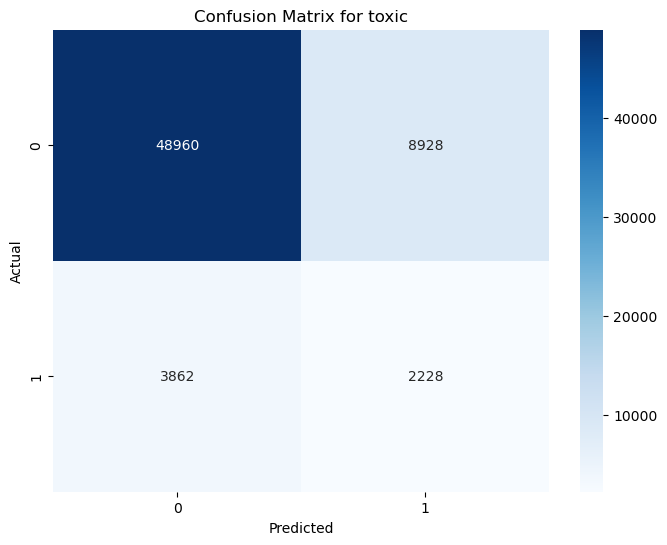

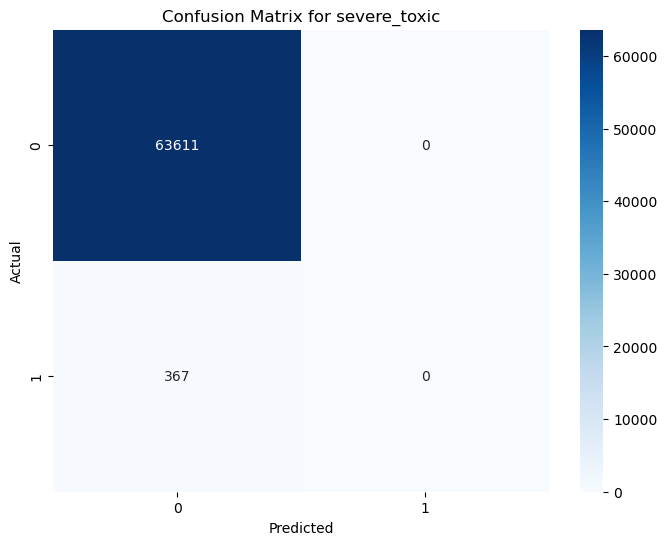

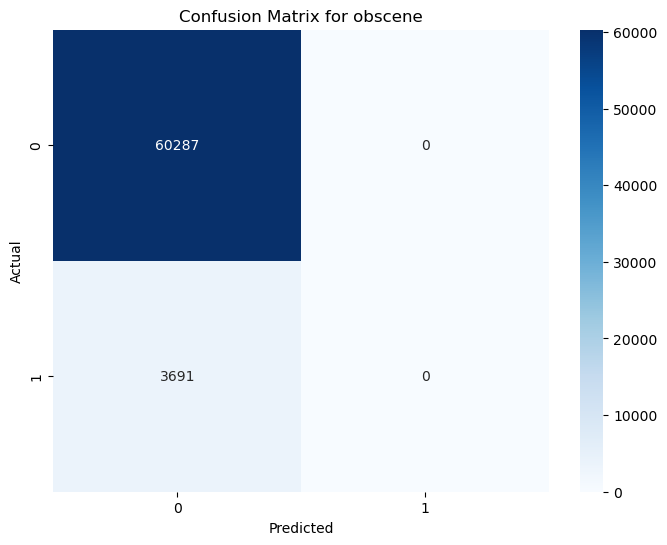

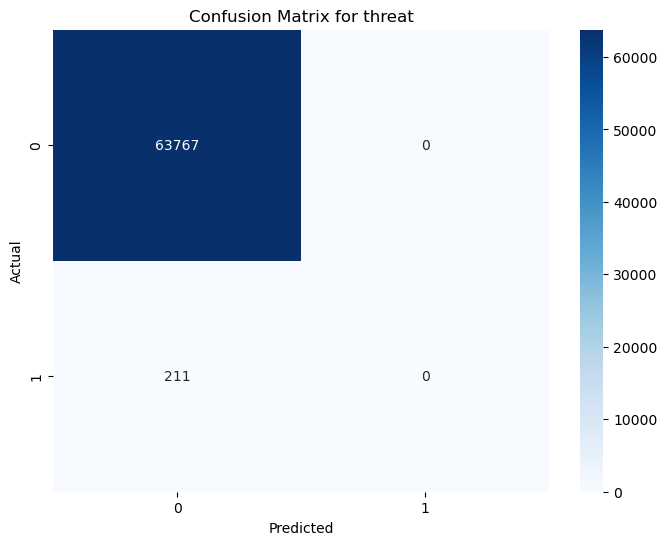

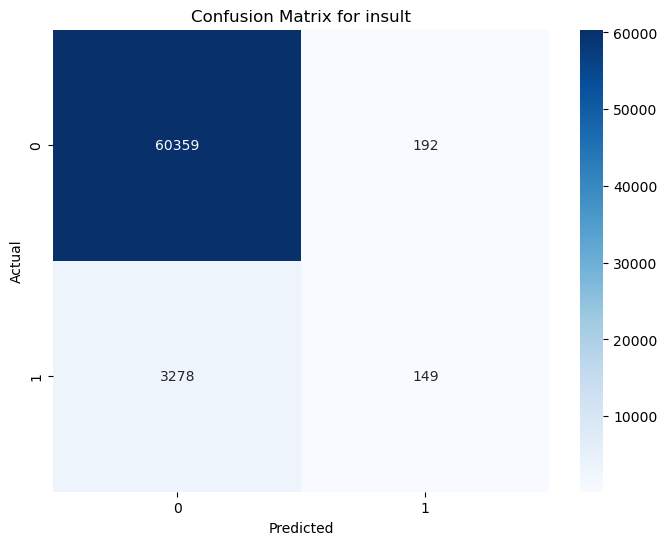

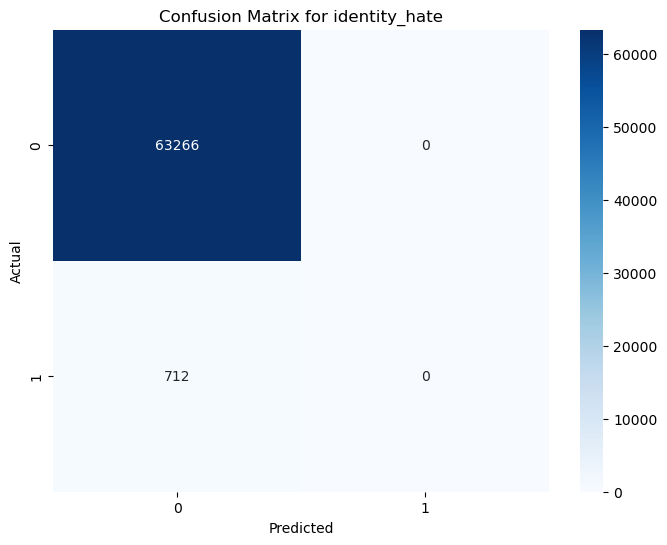

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

label_names = test_merged_df.columns[2:]  # Adjust this to your dataset's label column names
print(test_df_filtered.head())

for i, label in enumerate(label_names):
    cm = confusion_matrix(y_test.iloc[:, i], predictions[:, i])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

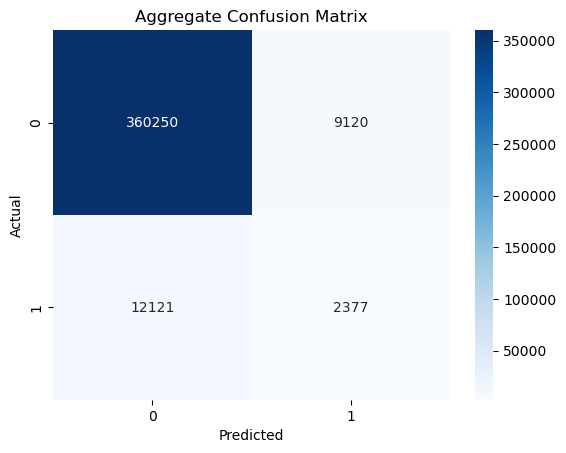

In [12]:
aggregate_cm = np.zeros((2, 2))
for i in range(y_test.shape[1]):
    aggregate_cm += confusion_matrix(y_test.iloc[:, i], predictions[:, i])

sns.heatmap(aggregate_cm, annot=True, fmt="g", cmap='Blues')
plt.title('Aggregate Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
cm = [
    [360250, 9120]
]